#Supervised Learning

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import re
import operator

First, let's load our dataframe with features calculated in the feature selection notebook:

In [2]:
%%time

import cPickle
import praw

df = cPickle.load(open('df_features.p', 'rb'))

Wall time: 51.9 s


In [3]:
df.head(3)

,_replies,_submission,author,body,body_html,controversiality,created,created_utc,downs,gilded,score,subreddit,thread,ups,character_count,time_delay,word_count,swear_count,word_size,link_count,italics_count,bold_count,strikethrough_count,blockquote_count,paragraph_count,i_author_flair_css_class,i_author_flair_text,i_distinguished,i_edited,i_score_hidden,i_banned_by,syn_count,syn_perc,un_length,un_punc,un_case,un_number,un_PM,un_bot
0,"[This one is rudimentary., chugada chugada chu...",4701 :: What is one sentence that people in yo...,SweetJesusRyan,It's just flam taps followed by a paradiddle a...,"<div class=""md""><p>It&#39;s just flam taps fol...",0,1432091072,1432062272,0,0,2485,AskReddit,36ih74,2485,60,7011,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,14,0,2,0.000000,0,0
1,"[Yes, we dont want any zombies hanging around....",4701 :: What is one sentence that people in yo...,Slak44,"If the parent isn't responding, just kill him ...","<div class=""md""><p>If the parent isn&#39;t res...",0,1432087085,1432058285,0,1,4983,AskReddit,36ih74,4983,63,3024,12,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,6,0,2,0.333333,0,0
2,"[Is your hobby being John Gruden?, This guy he...",4701 :: What is one sentence that people in yo...,rylnalyevo,FB is always the primary on Spider 2 Y Banana.,"<div class=""md""><p>FB is always the primary on...",0,1432090391,1432061591,0,0,2386,AskReddit,36ih74,2386,46,6330,10,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,10,0,0,0.000000,0,0


##Baseline

In [3]:
dftouse = df.copy()

Begin by standardizing the parts of the data that are integers or floats:

In [4]:
STANDARDIZABLE = ['created', 'created_utc', 'character_count', 'time_delay', 'word_count', 'swear_count',
                 'word_size', 'link_count', 'italics_count', 'bold_count', 'strikethrough_count', 'blockquote_count',
                 'paragraph_count', 'syn_count', 'syn_perc', 'un_length', 'un_punc', 'un_case', 'un_number']

Create the training and testing sets.

In [5]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [6]:
from sklearn.preprocessing import StandardScaler

def standardize(orig_df, change_df):
    for col in STANDARDIZABLE:
        valstrain = orig_df[col].values[mask]
        valstest = orig_df[col].values[~mask]
        scaler = StandardScaler().fit(valstrain)
        outtrain = scaler.transform(valstrain)
        outtest = scaler.fit_transform(valstest)
        out = np.empty(mask.shape[0])
        out[mask] = outtrain
        out[~mask] = outtest
        change_df[col] = out

standardize(df, dftouse)

C:\Program Files\Anaconda\envs\python2\lib\site-packages\sklearn\utils\validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


Let's build a baseline where we simply guess the number of upvotes a post will get by guessing using the mean and the median of the test set. We will define error using the **Mean Absolute Error**: given prediction vector ```y'``` and actual vector ```y```, our error is ```mean(abs(y' - y))```.

In [8]:
def baseline(indf, mask):
    X = indf['ups']
    if mask !=None:
        Xtrain, Xtest = X[mask], X[~mask]

    mean = np.mean(Xtrain)
    median = np.median(Xtrain)
    print mean, median
    training_error_mean = abs(Xtrain - mean)
    training_error_median = abs(Xtrain - median)
    
    test_error_mean = abs(Xtest - mean)
    test_error_median = abs(Xtest - median)
    
    training_accuracy1 = np.mean(training_error_mean)
    training_accuracy2 = np.mean(training_error_median)
    training_sd1 = np.std(training_error_mean)
    training_sd2 = np.std(training_error_median)
    test_accuracy1 = np.mean(test_error_mean)
    test_accuracy2 = np.mean(test_error_median)
    test_sd1 = np.std(test_error_mean)
    test_sd2 = np.std(test_error_median)
    
    print "############# Baseline Accuracy ########################"
    print "Training MAE using mean:                %0.2f" % (training_accuracy1)
    print "Training SD using mean:                 %0.2f" % (training_sd1)
    print "Training MAE using median:              %0.2f" % (training_accuracy2)
    print "Training SD using median:               %0.2f" % (training_sd2)
    print
    print "Training MAE using mean:                %0.2f" % (test_accuracy1)
    print "Test SD using mean:                     %0.2f" % (test_sd1)
    print "Training MAE using median:              %0.2f" % (test_accuracy2)
    print "Test SD using median:                   %0.2f" % (test_sd2)
    print "########################################################"

In [9]:
baseline(dftouse, mask)

79.8057273729 2.0
############# Baseline Accuracy ########################
Training MAE using mean:                144.96
Training SD using mean:                 470.34
Training MAE using median:              78.22
Training SD using median:               492.11

Training MAE using mean:                148.41
Test SD using mean:                     489.83
Training MAE using median:              81.78
Test SD using median:                   511.74
########################################################


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


##Adjustments, Processing, and Some Functions

First, let's create a smaller dataframe ```minidf``` to test models that take longer to run -- below, we randomly sample 10,000 rows in the original dataframe, and create a mask for ```minidf```.

In [10]:
import random
rows = random.sample(dftouse.index, 10000)
minidf = dftouse.ix[rows]

In [11]:
from sklearn.cross_validation import train_test_split
itrain2, itest2 = train_test_split(xrange(minidf.shape[0]), train_size=0.7)

mask2=np.ones(minidf.shape[0], dtype='int')
mask2[itrain2]=1
mask2[itest2]=0
mask2 = (mask2==1)

Another thing to note is that our data is very skewed: the vast majority of the comments have scores < 5, while the highest scoring comments have scores > 7000.

In [12]:
print "# comments with scores < 5", len(dftouse[dftouse['ups'] < 5])
print "# comments with scores > 7000", len(dftouse[dftouse['ups'] > 7000])

# comments with scores < 5 135285
# comments with scores > 7000 16


This heavily skewed data can cause our models to do poorly. We thus try to adjust by taking the log of the number of upvotes, stored in ```log_df```.

In [13]:
log_df = dftouse.copy()
log_df['ups'] = dftouse['ups'].map(lambda x: np.log(x) if x > 0 else 0)

Note the columns that we want to use as features in the regression.

In [7]:
cols = ['created_utc',
        'time_delay',
        'word_count',
        'character_count',
        'swear_count',
        'word_size',
        'link_count',
        'italics_count',
        'bold_count',
        'strikethrough_count',
        'blockquote_count',
        'paragraph_count',
        'syn_count',
        'syn_perc',
        'un_length',
        'un_punc',
        'un_case',
        'un_number',
        'un_PM',
        'un_bot'
        ]

Below is the function for optimizing parameters:

In [8]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

Below is the function to handle the regressions:

In [9]:
from sklearn.metrics import confusion_matrix

def classify(clf, parameters, indf, featurenames, targetname, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=indf[targetname].values
    if mask !=None:
        print "mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    # print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

##Botany and Ensemble Methods

###Decision Trees

We first try regression using Decision Trees; note that we use ```log_df```. The main issue for decision trees is overfitting -- from [the documentation](http://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use), to get a feel for how the tree is fitting the data, we use ```max_depth=3``` and ```min_samples_leaf=5```, then visualize the tree. 

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

//anaconda/lib/python2.7/site-packages/sklearn/tree/tree.py:32: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  from ._tree import Criterion


In [18]:
%%time

parameters = {"max_depth": [3], 'min_samples_leaf': [5]}
clftree, Xtrain, ytrain, Xtest, ytest = classify(
                              DecisionTreeRegressor(),
                              parameters, 
                              log_df, 
                              cols,
                              'ups',
                              mask = mask,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

tree.export_graphviz(clftree, out_file='tree.dot') # get the tree as a dot file, then convert to png

mask
BEST {'max_depth': 3, 'min_samples_leaf': 5} -0.738324675106 [mean: -0.73832, std: 0.02125, params: {'max_depth': 3, 'min_samples_leaf': 5}]
############# based on standard predict ################
Accuracy on training data: 0.28
Accuracy on test data:     0.27
########################################################
CPU times: user 2.3 s, sys: 166 ms, total: 2.47 s
Wall time: 2.91 s


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Below is the tree that results from ```max_depth=3``` and ```min_samples_leaf=5```: 

![Image of decision tree](images/decisiontree.png)

Judging by the MSE (mean squared error) of the children, we are not overfitting. We thus increase ```max_depth``` and ```min_samples_leaf```. We also save the feature importances in ```tree_feats```.

In [19]:
%%time

parameters = {"max_depth": [3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}
clftree, Xtrain, ytrain, Xtest, ytest = classify(
                              DecisionTreeRegressor(),
                              parameters, 
                              log_df, 
                              cols,
                              'ups',
                              mask = mask,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

tree_feats = zip(cols, clftree.feature_importances_)

mask
BEST {'max_depth': 5, 'min_samples_leaf': 3} -0.733551869776 [mean: -0.73832, std: 0.02125, params: {'max_depth': 3, 'min_samples_leaf': 1}, mean: -0.73832, std: 0.02125, params: {'max_depth': 3, 'min_samples_leaf': 2}, mean: -0.73832, std: 0.02125, params: {'max_depth': 3, 'min_samples_leaf': 3}, mean: -0.73832, std: 0.02125, params: {'max_depth': 3, 'min_samples_leaf': 4}, mean: -0.73832, std: 0.02125, params: {'max_depth': 3, 'min_samples_leaf': 5}, mean: -0.73832, std: 0.02125, params: {'max_depth': 3, 'min_samples_leaf': 6}, mean: -0.73553, std: 0.02646, params: {'max_depth': 4, 'min_samples_leaf': 1}, mean: -0.73553, std: 0.02646, params: {'max_depth': 4, 'min_samples_leaf': 2}, mean: -0.73553, std: 0.02646, params: {'max_depth': 4, 'min_samples_leaf': 3}, mean: -0.73553, std: 0.02646, params: {'max_depth': 4, 'min_samples_leaf': 4}, mean: -0.73553, std: 0.02646, params: {'max_depth': 4, 'min_samples_leaf': 5}, mean: -0.73553, std: 0.02646, params: {'max_depth': 4, 'min_samp

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Not too hot for R^2 accuracy scores. Let's look at the mean absolute error -- note that we take ```exp``` of the values to get back number of upvotes, instead of log of the upvotes.

In [20]:
print "Mean absolute error:", np.mean(abs(np.exp(clftree.predict(Xtest)) - np.exp(ytest)))
print "Standard deviation:", np.std(abs(np.exp(clftree.predict(Xtest)) - np.exp(ytest)))

Mean absolute error: 80.1969492949
Standard deviation: 491.614572262


This is barely better than the baseline of the median! Let's look at the final tree to see if we are overfitting:

In [21]:
tree.export_graphviz(clftree, out_file='tree2.dot')

![Image of decision tree](images/decisiontree2.png)

Judging by the MSE again, we are not overfitting.

###Random Forests

Now, let's try Random Forests. According to [the documentation](http://scikit-learn.org/stable/modules/ensemble.html#parameters), the main parameters to adjuct are ```n_estimators``` and ```max_features```. 

* ```n_estimators``` is the number of trees in the forest -- the more trees, the better but longer to compute. 

* ```max_features``` is the number of random subsets of features to consider when splitting a node. The documentation states that empirically, the default value of n_features (the number of features) is the best for regression.

* Good results can be achieved when using ```min_samples_split = 1```. ```min_samples_split``` is the minimum number of samples needed to split an internal node -- the default is 2, but if we set it equal to 1, the trees are fully developed (which has the downfall of using lots of RAM). 

* Finally, since we are building lots of trees, we want to run this in parallel: we thus set ```n_jobs=-1```, which means that the number of jobs is set to the number of cores.

In [36]:
from sklearn.ensemble import RandomForestRegressor

We run the regression below, and save the feature importances in ```forest_feats```.

In [199]:
%%time

parameters = {'n_estimators': range(10, 50), 
              'min_samples_split': [1, 2], 'n_jobs': [-1]}
clfforest, Xtrain, ytrain, Xtest, ytest = classify(
                              RandomForestRegressor(),
                              parameters, 
                              log_df, 
                              cols,
                              'ups',
                              mask = mask,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

forest_feats = zip(cols, clfforest.feature_importances_)

mask
BEST {'min_samples_split': 2, 'n_estimators': 41, 'n_jobs': -1} -0.873138750897 [mean: -0.90048, std: 0.02538, params: {'min_samples_split': 1, 'n_estimators': 10, 'n_jobs': -1}, mean: -0.90765, std: 0.03458, params: {'min_samples_split': 1, 'n_estimators': 11, 'n_jobs': -1}, mean: -0.90073, std: 0.03617, params: {'min_samples_split': 1, 'n_estimators': 12, 'n_jobs': -1}, mean: -0.89315, std: 0.03244, params: {'min_samples_split': 1, 'n_estimators': 13, 'n_jobs': -1}, mean: -0.90393, std: 0.02810, params: {'min_samples_split': 1, 'n_estimators': 14, 'n_jobs': -1}, mean: -0.88766, std: 0.03035, params: {'min_samples_split': 1, 'n_estimators': 15, 'n_jobs': -1}, mean: -0.89714, std: 0.03685, params: {'min_samples_split': 1, 'n_estimators': 16, 'n_jobs': -1}, mean: -0.89331, std: 0.02554, params: {'min_samples_split': 1, 'n_estimators': 17, 'n_jobs': -1}, mean: -0.88640, std: 0.02473, params: {'min_samples_split': 1, 'n_estimators': 18, 'n_jobs': -1}, mean: -0.89480, std: 0.03323, pa

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


The difference between the accuracy on training data and test data suggests that we are overfitting. Let's look at the MAE:

In [217]:
print "Mean absolute error:", np.mean(abs(np.exp(clfforest.predict(Xtest)) - np.exp(ytest)))
print "Standard deviation:", np.std(abs(np.exp(clfforest.predict(Xtest)) - np.exp(ytest)))

Mean absolute error: 80.6705627815
Standard deviation: 482.794761811


This is about the same as decision trees, and not much better than the median!

Let's pickle our models for validation:

In [22]:
cPickle.dump(clftree, open('clftree.p', 'wb'))
cPickle.dump(clfforest, open('clfforest.p', 'wb'))

###Feature Weighting

Let's take a look at how each model weighted the features we provided it. First, random forests:

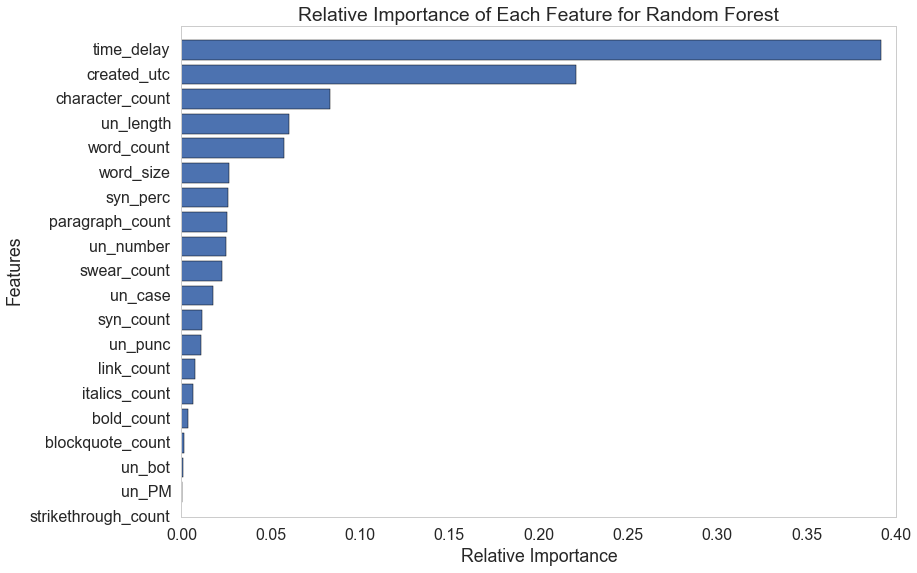

In [201]:
forest_feat_sort = sorted(forest_feats, key=lambda x: x[1])
plt.barh(range(len(forest_feats)), [x[1] for x in forest_feat_sort], align='center')
plt.yticks(range(len(forest_feats)), [x[0] for x in forest_feat_sort])
plt.title('Relative Importance of Each Feature for Random Forest')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.ylim([0, 20])
plt.grid()
plt.show()

Time was the most important factors, with ```time_delay``` as the most important feature, and ```created_utc``` coming in second. Also, the more general features were also ranked more important, such as ```character_count```,  ```word_count```, and ```un_length```, while the more obscure features like markdown and ```un_punc``` were less important.

Now let's look at decision trees: 

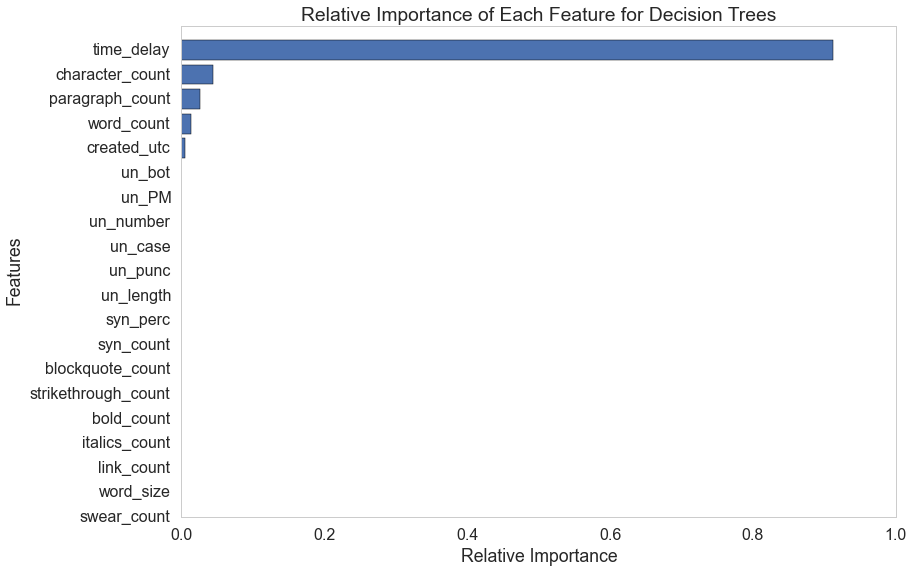

In [202]:
tree_feat_sort = sorted(tree_feats, key=lambda x: x[1])
plt.barh(range(len(tree_feats)), [x[1] for x in tree_feat_sort], align='center')
plt.yticks(range(len(tree_feats)), [x[0] for x in tree_feat_sort])
plt.title('Relative Importance of Each Feature for Decision Trees')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.ylim([0, 20])
plt.grid()
plt.show()

The distribution for decision trees is much more skewed, with a very heavy weighting on ```time_delay```. Interestingly, counts related to the comment body (```character_count```, ```paragraph_count```, and ```word_count```) come before the ```created_utc```, while the other features seem basically irrelevant.

Below is a comparison of the two graphs: the relative importance is more distributed for random forests compared to decision trees.

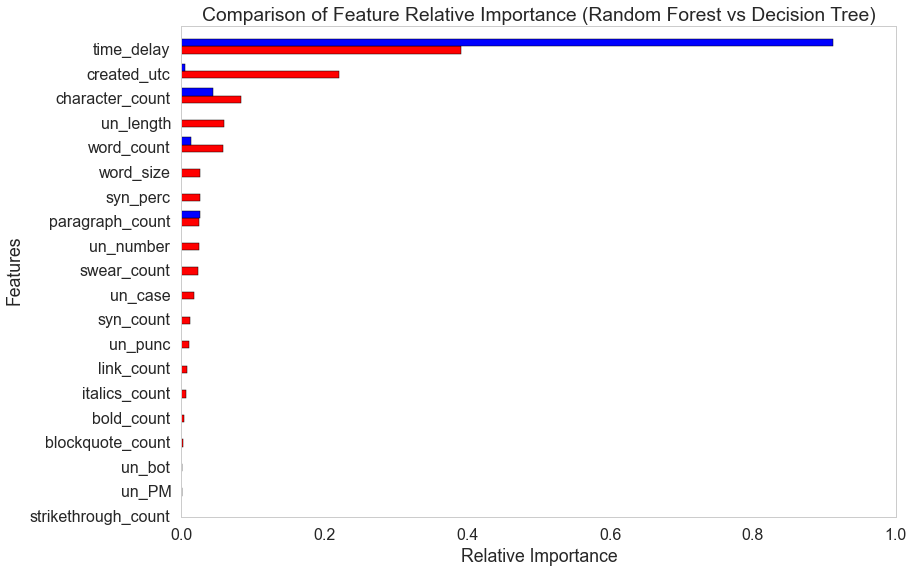

In [203]:
tree_feat_d = {x[0]:x[1] for x in tree_feats}
ordered_tree_feat = [tree_feat_d[x[0]] for x in forest_feat_sort]
bar_width = 0.3
plt.barh(range(len(forest_feats)), [x[1] for x in forest_feat_sort], bar_width, align='center', color='r')
plt.barh([i + bar_width for i in range(len(forest_feats))], ordered_tree_feat, bar_width, align='center', color='b')
plt.yticks(range(len(forest_feats)), [x[0] for x in forest_feat_sort])
plt.title('Comparison of Feature Relative Importance (Random Forest vs Decision Tree)')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.ylim([0, 20])
plt.grid()
plt.show()

This could be an explanation for the discrepancy between the random forest's accuracy scores. Since the relative importance of features is more distributed for random forests, it is possible that the model created over-complex trees, finding patterns among the features that are specific to the training set, but do not generalize (overfitting). 

##Logistic Regression

Next we will try to use a logistic regression with multiple classes. Here we run the regression:

In [82]:
from sklearn.linear_model import LogisticRegression

In [ ]:
%%time

cs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

clflog, Xtrain, ytrain, Xtest, ytest = classify(
                              LogisticRegression(penalty="l2", solver='lbfgs', multi_class='multinomial'),
                              {"C": cs}, 
                              minidf, 
                              cols,
                              'ups',
                              mask = mask2,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

Now let's take a look at what the average error and compare that to the baseline.

In [135]:
errorslr = abs(clflog.predict(Xtest) - ytest)
print np.mean(errorslr)
print np.std(errorslr)

73.4613333333


If we plot the frequency of the errors, we can see the regression does slightly better than just using the median. 

In [ ]:
plt.hist(errorslr, bins=np.arange(0,50,1), alpha=0.5);
plt.title('Errors Using Logistic');
plt.xlabel('Error');
plt.ylabel('Occurences');

We pickle the model so that we can use it later for prediction.

In [ ]:
cPickle.dump(clflog, open('clflog.p', 'wb'))

##K Neighbors

We can also try a k-neighbors classifier. 

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
%%time

#neighbors = np.arange(60,120,5)

clfkn, Xtrain, ytrain, Xtest, ytest = classify(
                              KNeighborsClassifier(),
                              {"n_neighbors": [70,100,130]}, 
                              dftouse, 
                              cols,
                              'ups',
                              mask = mask,
                              score_func = 'mean_absolute_error',
                              n_folds = 5
                              )

mask
BEST {'n_neighbors': 130} -79.2654700662 [mean: -79.27601, std: 99.07546, params: {'n_neighbors': 70}, mean: -79.27080, std: 99.07517, params: {'n_neighbors': 100}, mean: -79.26547, std: 99.07450, params: {'n_neighbors': 130}]
############# based on standard predict ################
Accuracy on training data: 0.44
Accuracy on test data:     0.43
########################################################
Wall time: 48min 38s


C:\Program Files\Anaconda\envs\python2\lib\site-packages\IPython\kernel\__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Let's take another look at the average absolute error. 

In [14]:
errorskn = abs(clfkn.predict(Xtest) - ytest)
print np.mean(errorskn)
print np.std(errorskn)

79.3944577143
502.302390593


Similar to what was done above for the regression, let's plot the occurences for each error. 

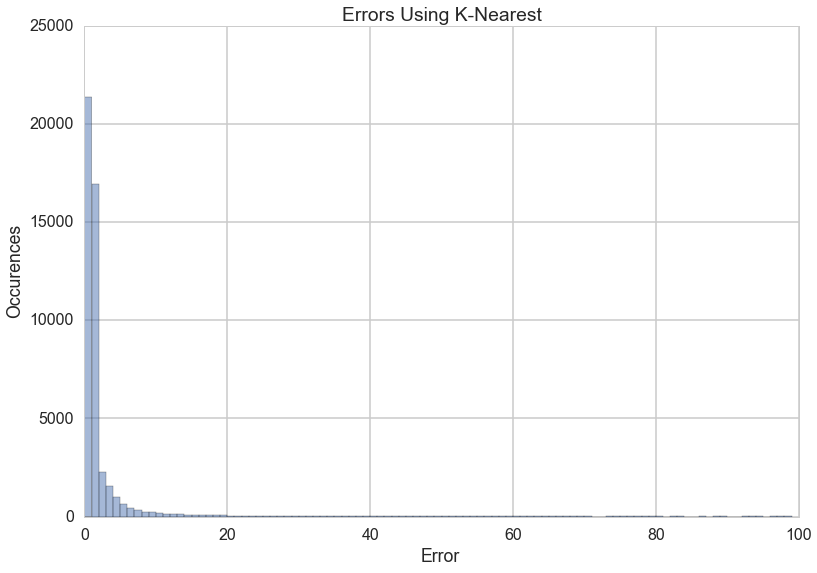

In [15]:
plt.hist(errorskn, bins=np.arange(0,100,1), alpha=0.5);
plt.title('Errors Using K-Nearest');
plt.xlabel('Error');
plt.ylabel('Occurences');

And, lastly, pickle the model to be used later.

In [16]:
cPickle.dump(clfkn, open('clfkn.p', 'wb'))